# Main Imports

In [1]:
import pandas as pd
import numpy as np
import re, string

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer

# Load in Data

In [2]:
#Data taken from https://nijianmo.github.io/amazon/index.html
# The '"Small" subsets for experimentation' "Electronics" 5-core (6,739,590 reviews)'
# was used.  There is a corresponding 'ratings only' file available as well.

#This took 62 minutes on my machine.

#amazon = pd.read_json('/<DirectoryWhereFileIs>/<UserID>/Electronics_5.json', lines=True) #Full dataframe

amazon = pd.read_json('/Users/johnmetzger/Desktop/Coding/Projects/Project4/Data/Electronics_5.json', lines=True) #Full dataframe

## Set Column Width

In [3]:
#(optional) To allow all the columns of the dataframe to be viewed in the 
# output window

pd.set_option('display.max_columns', None)

## Subsample

In [7]:
#At 1% this should take 1-2 minutes

amazon_ss = amazon.sample(frac = 0.01) #1% subsample for testing locally

In [96]:
amazon_ss;

# Pre-Processing

## Drop rows with empty 'reviewText' values

In [8]:
#This should not be large for this project

amazon_ss['reviewText'].replace('', np.nan, inplace=True)
amazon_ss.dropna(subset=['reviewText'], inplace=True)

## Reset Index

In [9]:
#Original index is now "Id" column and index=index

amazon_ss = amazon_ss.reset_index().set_index('index')

## Replace() Specific Data

In [10]:
amazon_ss['reviewText'] = amazon_ss['reviewText'].astype(str)

In [11]:
amazon_ss['reviewText'] = amazon_ss['reviewText'].apply(lambda x: x.replace('<p>',''))
amazon_ss['reviewText'] = amazon_ss['reviewText'].apply(lambda x: x.replace('</p>',''))

In [12]:
len(amazon_ss['reviewText'])

67380

## Remove HTML Tags and Line Breaks

In [13]:
#Function for removing html and line breaks.  Can sub '<html>' in for blank spaces
# if you want to visually track how many html occurences there were. I suppose you
# could count them later too.

TAG_RE = re.compile(r'<[^>]+>')
LINE_BREAK = re.compile(r'\n')

def remove_tags_line_breaks(text):
    new_text = TAG_RE.sub(' ', text)
    new_text = LINE_BREAK.sub(' ', new_text)
    return new_text

In [14]:
#Run the function using 'apply()' rather than 'map()'

amazon_ss['reviewText'] = amazon_ss['reviewText'].apply(remove_tags_line_breaks)

## Remove Punctuation

In [15]:
#maketrans() and trans() used for english puncutation.

translator = str.maketrans('','',string.punctuation)
amazon_ss['reviewText'] = amazon_ss['reviewText'].str.translate(translator)

## Lowercasing

In [16]:
amazon_ss['reviewText'] = [i.lower() for i in amazon_ss['reviewText']]
amazon_ss['reviewText']

index
6078499    i have one of these mini dell computers in whi...
2703202    i have always been a wd person but the price w...
1754674    i use this every work day i got it just becaus...
3643908    15 minute installation cant even tell its on m...
1450565    i have two gopro vented helmet straps one on m...
                                 ...                        
3305766    they have adequate sound quality and i can use...
457552     works great helped to receive signal with more...
3802572    with screen protector great protection for my ...
746534     i had high hopes that these would be a low cos...
5160595                                        great product
Name: reviewText, Length: 67380, dtype: object

# CountVectorizer

In [41]:
#I used the standard CountVectorizer, but TfidfVectorizer is another option.

vectorizer = CountVectorizer(stop_words='english', max_features = 5000)
doc_word = vectorizer.fit_transform(amazon_ss['reviewText'])
doc_word.shape

(67380, 5000)

In [18]:
#Output is a sparse matrix.  The number of stored elements should be much
# less than multiplying populated matrix.  Here, 1.5e^6 vs 3.4e^8 ~ 0.4%.

doc_word

<67380x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 1476027 stored elements in Compressed Sparse Row format>

# NMF

In [106]:
#Non-negative Matrix Factorization

nmf_model = NMF(n_components=20)
doc_topic = nmf_model.fit_transform(doc_word)

In [125]:
doc_topic_df = pd.DataFrame(doc_topic)

In [126]:
#This cell is for n_components=20.  You have to add comlumn titles.

topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2", "component_3", "component_4","component_5",
                     "component_6", "component_7", "component_8", "component_9","component_10",
                      "component_11","component_12", "component_13", "component_14","component_15",
                     "component_16", "component_17", "component_18", "component_19","component_20"],
             columns = vectorizer.get_feature_names())

In [127]:
# Don't try to look at the full output or the notebook might freeze and break.

topic_word;

In [128]:
#This function outputs the topics and most relevant words.

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [129]:
#Note the number of words that corresponds to a topic is given and corresponds to
# 'no_top_words' in the preceeding functino cell.

display_topics(nmf_model, vectorizer.get_feature_names(), 20)


Topic  0
battery, batteries, charge, charger, life, charging, power, hours, phone, grip, long, usb, time, charged, bluetooth, speaker, radio, canon, used, original

Topic  1
camera, cameras, video, quality, pictures, image, photos, zoom, canon, sony, shoot, light, mode, picture, flash, digital, point, does, dslr, want

Topic  2
time, unit, work, product, im, new, ive, did, dont, got, bought, phone, used, problem, amazon, didnt, update, buy, review, service

Topic  3
case, ipad, cover, fans, fan, cpu, cases, fit, inside, build, cooler, nice, fits, kindle, power, place, leather, protection, air, stand

Topic  4
tv, remote, picture, samsung, set, 4k, tvs, dvd, hdmi, channels, box, hd, 3d, player, wall, quality, netflix, mount, amazon, screen

Topic  5
great, price, product, easy, love, little, quality, buy, worked, recommend, nice, bought, really, looks, fast, value, highly, perfect, fits, got

Topic  6
drive, usb, hard, drives, windows, laptop, computer, ssd, external, 30, power, data, 

# Check Most Relevant Reviews

In [130]:
#doc_topic_df.sort_values(topic_num).tail(tail_row_num)

doc_topic_df.sort_values(1).tail(5)



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
42651,0.496682,2.081686,0.337572,0.000000,0.142740,0.100513,0.073923,0.697647,0.362713,0.532290,0.918598,0.000000,0.000000,0.815133,0.000000,0.064198,0.000000,0.243435,0.417666,0.000000
5892,0.523687,2.138953,0.000000,0.000000,0.000000,0.185501,0.028378,0.192588,0.333163,0.100852,0.571434,0.021565,0.053296,0.000000,0.001746,0.000000,0.035676,0.000000,0.212619,0.007313
41164,0.103995,2.224022,0.162385,0.023139,0.041913,0.519552,0.112122,0.294889,0.659881,0.849864,0.894433,0.072080,0.179964,0.282635,0.000000,0.019816,0.073674,0.240606,0.583291,0.819188
36754,0.000000,2.881557,0.114135,0.044782,0.000000,0.000000,0.000000,0.000000,0.109188,0.373285,0.000000,0.000000,0.042709,0.000000,0.116709,0.000000,0.085854,0.495219,0.150239,0.000000
62819,0.651754,3.178718,0.233908,0.032163,0.050288,0.352221,0.000000,0.252729,0.737766,0.352807,0.110215,0.049510,0.000000,0.126349,0.047909,0.165917,0.192692,0.000000,0.712626,0.042271


In [173]:
amazon_ss['reviewText'].astype(str)

#This will find the number of words.
count = amazon_ss['reviewText'].str.split().str.len()
pd.Series(count)
amazon_ss['reviewText_len']=count
amazon_ss.reset_index()
amazon_ss

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,reviewText_len
index,,,,,,,,,,,,,
6078499,5,NaN,True,"12 8, 2017",A2KYTH8OIV7E18,B01GW5M6B2,NaN,PiyoPiyo,i have one of these mini dell computers in whi...,I have one of these mini Dell computers in whi...,1512691200,NaN,61
2703202,5,NaN,True,"08 29, 2014",A3PF5VEKQCHEBJ,B00829TIIQ,"{'Color:': ' Black', 'Capacity:': ' 1 TB'}",Dean,i have always been a wd person but the price w...,Good Drive,1409270400,NaN,57
1754674,5,NaN,True,"07 28, 2015",A2CUIBSXNS741L,B0043T7FXE,NaN,MGD,i use this every work day i got it just becaus...,Fantastic,1438041600,NaN,84
3643908,5,NaN,True,"07 23, 2016",AW9B7CUDSYHR6,B00EL94Z4I,NaN,Jordan,15 minute installation cant even tell its on m...,Five Stars,1469232000,NaN,10
1450565,5,NaN,True,"09 15, 2012",A3AI9W4LQC0DTI,B002EF2200,{'Color:': ' One Color'},edgar arsenal,i have two gopro vented helmet straps one on m...,nice gopro,1347667200,NaN,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3305766,5,NaN,True,"02 5, 2014",A4K3AD1SAJH5K,B00C7JIBN0,{'Product Packaging:': ' Standard Packaging'},South St. Louis,they have adequate sound quality and i can use...,Great for the price.,1391558400,NaN,45
457552,5,NaN,True,"08 27, 2015",ASP0OL0TW458M,B000F28DP2,{'Size:': ' 1 Port'},OZARK TWO,works great helped to receive signal with more...,Five Stars,1440633600,NaN,15
3802572,5,NaN,True,"12 17, 2014",AGLWST5RM8LIZ,B00FUUPUJQ,{'Color:': ' Black'},SpinChin,with screen protector great protection for my ...,Great protection!,1418774400,NaN,41


In [174]:
amazon_ss_df=pd.DataFrame(amazon_ss['reviewText_len']).reset_index()

# amazon_ss['reviewText_len'] = amazon_ss['reviewText_len'].astype(float) #Make type 'string' for len count
doc_topic_df['reviewText_len'] = amazon_ss_df['reviewText_len']
doc_topic_df

,index,reviewText_len
0,6078499,61
1,2703202,57
2,1754674,84
3,3643908,10
4,1450565,20
...,...,...
67375,3305766,45
67376,457552,15
67377,3802572,41
67378,746534,198


# WordCloud

In [115]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt

In [117]:
world_cloud_word = doc_word

comment_words = '' 
stopwords = set(STOPWORDS)

In [118]:
for val in amazon_ss.reviewText: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+""

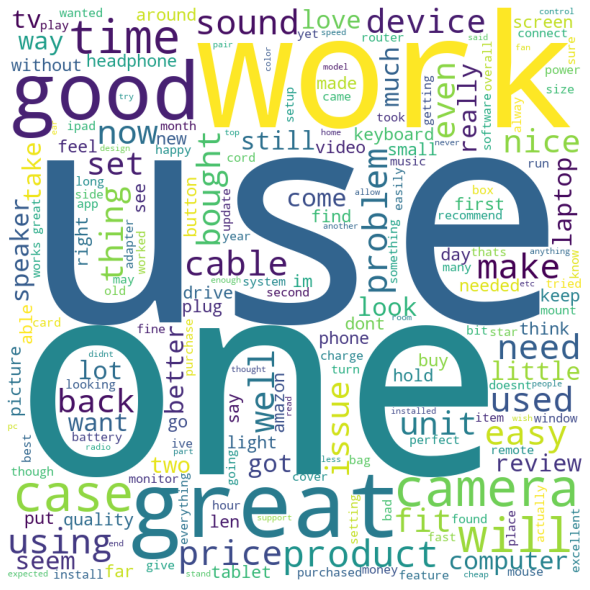

In [119]:
#The wordcloud isn't a super helpful quantitative device, but it does
# offer us some idea of what is going on with the frequencies of different
# words. It helped me see some words pairings I might have missed from just
# a dataframe or list ouput, but use with caution.

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Export Processed SubSample Data for Further Work

In [120]:
amazon_ss.to_csv('amazon_ss.csv')